In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
Trans = lambda x: 10**(-0.2*x/10)
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

# no cutoff
For reference

In [4]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_parallel_no_cutoff(τ_coh, mu_link, F_link, links, cct= True, Nmax=10000):
    """ Runs Monte-Carlo iterations to calculate performance metrics for asynchronous parallel scheme
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
        cct: bool flag to turn on/off classical comm.
        Nmax: No. of MC iterations (if you see oscillations in secret key curves, you need to try larger numbers)

    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    Nmax = int(Nmax) # to make sure Nmax is an integer
    if type(links) != np.ndarray:
        links = np.array(links)
        
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
    for i in range(1,N_links):
        Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
    
    Ts = np.zeros((N_links-1,Nmax))
    Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    for i in range(1,N_links-1):
        Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
    f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    if cct: # inclduing classical comm. 
        Tsw = np.zeros((N_links-1,Nmax))
        Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
        for i in range(1,N_links-1):
            Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
        T_tot = np.mean(np.max(Tsw,axis=0))           
        Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] 
        Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] 
        f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    else:
        T_tot = np.mean(np.max(Ns,axis=0))
        Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] 
        Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] 
        f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    raw_rate = 1/T_tot
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    return raw_rate, skr, F_e2e


def T_sequential_no_cutoff(τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    T_tot = 2* np.sum( τs / (p_link*Trans(links)) )

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod(p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) ) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    return raw_rate, skr, F_e2e


# One repeater with cutoff

In [6]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=100000):
    """ calculates the performance of parallel scheme with one repeater
    inputs:
        L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        Nmax: ensemble size for averaging
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    Nmax = int(Nmax) # to make sure Nmax is an integer
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
    t1L = Ts-(2*N1-1)*τ1 # elapsed time of leftside repeater's memory 
    t1R = Ts-2*(N2-1)*τ2 # elapsed time of rightside repeater's memory 
    indsL = np.argwhere( t1L <= τ_cut )[:,0]
    indsR = np.argwhere( t1R <= τ_cut )[:,0]
    succ_inds = np.intersect1d(indsL,indsR)
    T_succ = np.sum(Ts[succ_inds]+ τ1) 
    fail_inds = list(set(list(range(Nmax)))-set(succ_inds))
    # L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 ).shape[0]
    # R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 ).shape[0]
    # T_fail = (2*τ1/p1 + τ_cut)*L_runs + (2*τ2*(1/p2-1)+τ1 + τ_cut)*R_runs
    # T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
    L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 )[:,0]
    R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 )[:,0]
    # print(list(np.array(fail_inds)[L_runs]))
    left_mem_on_idx = list(np.array(fail_inds)[L_runs])
    right_mem_on_idx = list(np.array(fail_inds)[R_runs])
    T_elapsed_left = 2*N1[left_mem_on_idx]*τ1 + τ_cut
    T_elapsed_right = 2*(N2[right_mem_on_idx]-1)*τ2 +τ1+ τ_cut
    T_fail = np.sum(T_elapsed_left)+np.sum(T_elapsed_right)

    mean_succ =  T_succ/len(succ_inds)
    mean_fail = T_fail/len(fail_inds)
    # print("Mean succ time: ", T_succ/len(succ_inds))
    # print("Mean fail time: ", T_fail/len(fail_inds))
    # print("success prob", len(succ_inds)/Nmax)
    # print("fail prob", len(fail_inds)/Nmax)

    raw_rate = len(succ_inds)/(T_succ+T_fail)
    t_idle_qkd = t1L + t1R
    f_memory_qkd = np.mean(np.exp(- t_idle_qkd[succ_inds]/τ_coh) )
    N_links = 2
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    tA = Ts+ τ1 -2*(N1-1)*τ1 # elapsed time of A's memory 
    tB = Ts+ τ1 -(2*N2-1)*τ2 # elapsed time of B's memory 
    t_idle_bell = tA + tB + t1L + t1R
    f_memory_bell = np.mean(np.exp(- t_idle_bell[succ_inds]/τ_coh) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
    # print(f"t1L = {np.mean(t1L)}, t1R = {np.mean(t1R)}")
    # print(f"t1L = {np.mean(t1L[succ_inds])}, t1R = {np.mean(t1R[succ_inds])}")
    return raw_rate, skr, F_e2e, mean_succ, mean_fail

def T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link):
    """ calculates the performance of parallel scheme with one repeater
    inputs:
        L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    τ1 = L1/c
    τ2 = L2/c
    m = int(τ_cut/(2*τ2))
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    # Q2m = (1-p2)**m
    P2m = 1- (1-p2)**m
    Nm = lambda x: (1-(1+m*x)*(1-x)**m)/x
    Tm = 2*τ1/(p1*P2m) +  (1/P2m-1)*τ_cut +Nm(p2)/P2m*2*τ2 

    raw_rate = 1/(Tm)
    # t1L = Nm(p2)/P2m*2*τ2
    # t1R = 2*τ2
    f_memory_qkd = p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-2*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-2*τ2/τ_coh) ) 
    N_links = 2
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    τe2e = τ1 + τ2
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-4*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-4*τ2/τ_coh) ) 
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
    return raw_rate, skr, F_e2e


## Rate vs distance

In [15]:
τ_coh = 0.01
τ_cut = 2*τ_coh # cutoff
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Le2e_list = np.linspace(10,200,21) # e2e distance [km]
raw_rate_par = np.zeros(len(Le2e_list))
raw_rate_seq = np.zeros(len(Le2e_list))
skr_par = np.zeros(len(Le2e_list))
skr_seq = np.zeros(len(Le2e_list))
Fe2e_par = np.zeros(len(Le2e_list))
Fe2e_seq = np.zeros(len(Le2e_list))

for i, Le2e in enumerate(Le2e_list):
    L1 = Le2e/2
    L2 = Le2e-L1 #Le2e/2
    raw_rate_par[i], skr_par[i], Fe2e_par[i] = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
    raw_rate_seq[i], skr_seq[i], Fe2e_seq[i] = T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link)


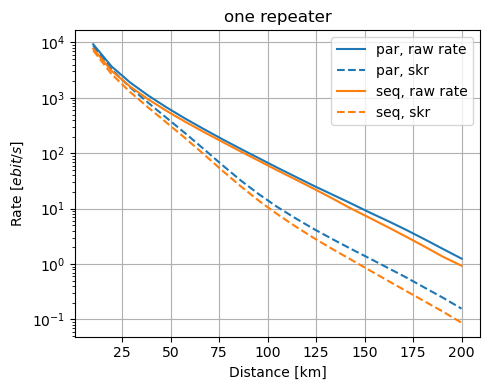

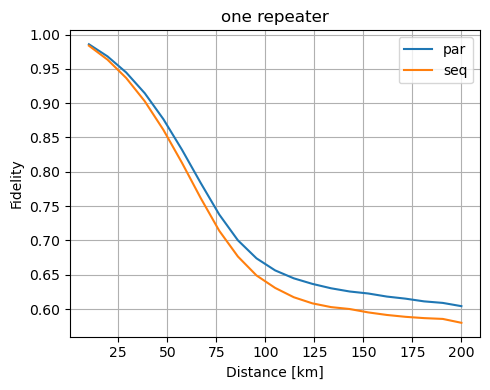

In [16]:
plt.figure(figsize=(5,4))
# plt.plot(Le2e_list,-np.log2(1-Trans(Le2e_list)),"k--", label="PLOB")
plt.plot(Le2e_list,raw_rate_par,"-",color="C0", label="par, raw rate")
plt.plot(Le2e_list,skr_par,"--",color="C0", label="par, skr")
plt.plot(Le2e_list,raw_rate_seq,"-",color="C1", label="seq, raw rate")
plt.plot(Le2e_list,skr_seq,"--",color="C1", label="seq, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.title(f"one repeater")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


plt.figure(figsize=(5,4))
plt.plot(Le2e_list,Fe2e_par,"-", label="par")
plt.plot(Le2e_list,Fe2e_seq,"-", label="seq")
plt.title(f"one repeater")
# plt.yscale("log")
plt.xlabel("Distance [km]")
# plt.ylabel(r"$T_{mem}/τ_{coh}$")
plt.ylabel("Fidelity")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
plt.show()


## Rate vs. cutoff time

In [9]:
τ_coh = 0.1 # coherence time [sec]
τ_cut_list = np.linspace(0.01,1.0)*τ_coh # cutoff [sec]
Le2e = 150 # e2e distance [km]
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

raw_rate_par = np.zeros(len(τ_cut_list))
skr_par = np.zeros(len(τ_cut_list))
Fe2e_par = np.zeros(len(τ_cut_list))
raw_rate_seq = np.zeros(len(τ_cut_list))
skr_seq = np.zeros(len(τ_cut_list))
Fe2e_seq = np.zeros(len(τ_cut_list))

for i_t, τ_cut in enumerate(τ_cut_list):
    L1 = Le2e/2
    L2 = Le2e/2
    raw_rate_par[i_t], skr_par[i_t], Fe2e_par[i_t] = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
    raw_rate_seq[i_t], skr_seq[i_t], Fe2e_seq[i_t] = T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link)


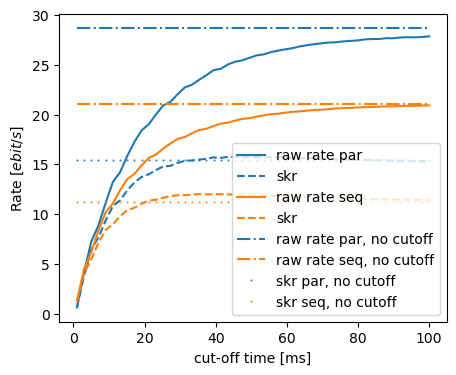

In [14]:
plt.figure(figsize=(5,4))
plt.plot(τ_cut_list*1e3,raw_rate_par,"-",color="C0",label="raw rate par")
plt.plot(τ_cut_list*1e3,skr_par,"--",color="C0",label="skr")

plt.plot(τ_cut_list*1e3,raw_rate_seq,"-",color="C1",label="raw rate seq")
plt.plot(τ_cut_list*1e3,skr_seq,"--",color="C1",label="skr")

# for reference:
raw_rate_par_no_cut, skr_par_no_cut, _  = T_parallel_no_cutoff(τ_coh, mu_link, F_link, [Le2e/2,Le2e/2], cct= True, Nmax=1e6)
raw_rate_seq_no_cut, skr_seq_no_cut, _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, [Le2e/2,Le2e/2])
plt.plot(τ_cut_list*1e3,raw_rate_par_no_cut+0*τ_cut_list , "-." ,color="C0",label="raw rate par, no cutoff")
plt.plot(τ_cut_list*1e3,raw_rate_seq_no_cut+0*τ_cut_list , "-." ,color="C1",label="raw rate seq, no cutoff")
plt.plot(τ_cut_list*1e3,skr_par_no_cut+0*τ_cut_list , ".", markersize=1 ,color="C0",label="skr par, no cutoff")
plt.plot(τ_cut_list*1e3,skr_seq_no_cut+0*τ_cut_list , ".", markersize=1 ,color="C1",label="skr seq, no cutoff")

plt.ylabel(r"Rate $[ebit/s]$")
plt.xlabel("cut-off time [ms]")
plt.legend()
plt.show()


# One repeater
fixed distance, repeater location sweeping

In [36]:
Le2e = 250 # e2e distance [km]
τ_coh = 0.1
τ_cut = 0.5*τ_coh # cutoff
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

δ = 0.1
rep_loc = np.linspace(δ,1-δ,40)
raw_rate_par = np.zeros(len(rep_loc))
skr_par = np.zeros(len(rep_loc))
Fe2e_par = np.zeros(len(rep_loc))
raw_rate_seq = np.zeros(len(rep_loc))
skr_seq = np.zeros(len(rep_loc))
Fe2e_seq = np.zeros(len(rep_loc))

for i, pos in enumerate(rep_loc):
    L1 = pos*Le2e
    L2 = Le2e - L1
    raw_rate_par[i], skr_par[i], Fe2e_par[i] = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
    raw_rate_seq[i], skr_seq[i], Fe2e_seq[i] = T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link)


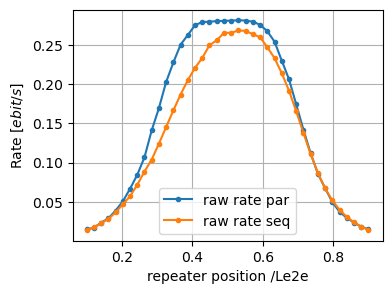

In [37]:
plt.figure(figsize=(4,3))

plt.plot(rep_loc,raw_rate_par,".-",color="C0",label="raw rate par")
plt.plot(rep_loc,raw_rate_seq,".-",color="C1",label="raw rate seq")
plt.xlabel("repeater position /Le2e")
plt.ylabel(r"Rate $[ebit/s]$")
plt.grid()
plt.legend()
plt.show()

In [31]:
2*Le2e/c

0.004